# Pneumonia Detection from Chest Xray Transfer Learning InceptionV3

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [2]:
Path = '../chest_xray/chest_xray/'

In [3]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(Path + _set + '/NORMAL'))
    n_infect = len(os.listdir(Path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [4]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [5]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
test_data.shape

(624, 150, 150, 3)

In [7]:
inputs = Input(shape=(img_dims, img_dims, 3))

from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(img_dims, img_dims, 3))
x = base_model.output

x = Dropout(0.5)(x)
from keras.layers import GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1,activation = 'sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 124s 762ms/step - loss: 0.2698 - accuracy: 0.9116 - val_loss: 6.4178 - val_accuracy: 0.6299
Epoch 2/10
163/163 [==============================] - 90s 550ms/step - loss: 0.1624 - accuracy: 0.9452 - val_loss: 0.3839 - val_accuracy: 0.8818
Epoch 3/10
163/163 [==============================] - 90s 550ms/step - loss: 0.1927 - accuracy: 0.9262 - val_loss: 117795.2344 - val_accuracy: 0.3699
Epoch 4/10
163/163 [==============================] - 90s 549ms/step - loss: 0.1660 - accuracy: 0.9410 - val_loss: 0.2405 - val_accuracy: 0.8328
Epoch 5/10
163/163 [==============================] - 90s 550ms/step - loss: 0.1762 - accuracy: 0.9302 - val_loss: 0.6451 - val_accuracy: 0.6976

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/10
163/163 [==============================] - 89s 547ms/step - loss: 0.1544 - accuracy: 0.9429 - val_loss: 2.9327 - val_accuracy: 0.6605
Epoch 7/10
163/163 [=======================

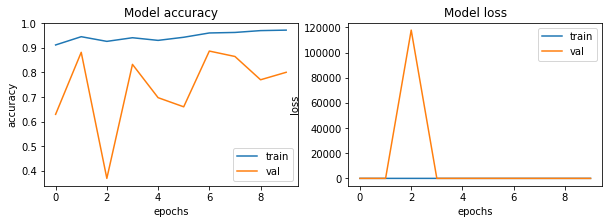

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[127 107]
 [  5 385]]

TEST METRICS ----------------------
Accuracy: 82.05128205128204%
Precision: 78.2520325203252%
Recall: 98.71794871794873%
F1-score: 87.3015873015873

TRAIN METRIC ----------------------
Train acc: 97.18


In [13]:
import seaborn as sn

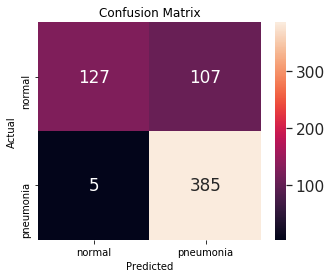

In [14]:
df_cm = pd.DataFrame(cm, index = ('normal', 'pneumonia'), columns = ('normal', 'pneumonia'))
plt.figure(figsize = (5,4))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()